# Agentic Analysis
This is an analysis of the KYB AI Agent output data. 

In [6]:
import pandas as pd
import numpy as np
import os
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()

conn_params = {
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT", "5432"),
}

def fetch_table_as_dataframe(table_name, where_clause=None, params=None):
    """
    Fetch an entire PostgreSQL table and convert it to a pandas DataFrame.
    
    Args:
        table_name (str): Name of the table to fetch
        where_clause (str, optional): WHERE clause for filtering (without 'WHERE' keyword)
        params (tuple, optional): Parameters for the WHERE clause
    
    Returns:
        pd.DataFrame: The table data as a DataFrame
    """
    with psycopg2.connect(**conn_params) as conn:
        with conn.cursor() as cur:
            # Build the query
            if where_clause:
                query = f"SELECT * FROM raw_data.{table_name} WHERE {where_clause}"
            else:
                query = f"SELECT * FROM raw_data.{table_name}"
            
            # Execute query
            if params:
                cur.execute(query, params)
            else:
                cur.execute(query)
            
            # Fetch all rows and column names
            rows = cur.fetchall()
            columns = [desc[0] for desc in cur.description]
    
    # Create DataFrame
    df = pd.DataFrame(rows, columns=columns)
    print(f"Table '{table_name}': {len(df)} rows fetched")
    return df

kyb_job_df = fetch_table_as_dataframe("raw_kyb_job")
# Display the results
print(f"DataFrame shape: {kyb_job_df.shape}")
print("\nFirst few rows:")
print(kyb_job_df.head())

Table 'raw_kyb_job': 15 rows fetched
DataFrame shape: (15, 12)

First few rows:
   id                                job_id  entity_id     status  \
0   1  a519f5da-ac04-429d-a0c9-97fd08fbcc08      72067  succeeded   
1   2  e35f03ff-893d-4e42-af59-7e8a9486fd88      73245  succeeded   
2   3  08183559-abf1-4265-84fa-bbd00403cb94      73260  succeeded   
3   5  72c748cd-81b8-4a36-8bfc-093011714fdf      73256  succeeded   
4   8  4207c801-c814-4089-86ad-8c3a894578b4      73103  succeeded   

        decision risk_score  \
0  Manual Review       5.00   
1  Manual Review       3.00   
2  Manual Review       3.00   
3  Manual Review       3.00   
4  Manual Review       3.00   

                                       justification  \
0  Company risk: high; Document rules not fully s...   
1                 Document rules not fully satisfied   
2                 Document rules not fully satisfied   
3                 Document rules not fully satisfied   
4                 Document rules not f

In [6]:
print(kyb_job_df.describe(include='all'))

               id                                job_id     entity_id  \
count   15.000000                                    15     15.000000   
unique        NaN                                    15           NaN   
top           NaN  a519f5da-ac04-429d-a0c9-97fd08fbcc08           NaN   
freq          NaN                                     1           NaN   
mean    10.066667                                   NaN  73176.133333   
min      1.000000                                   NaN  72067.000000   
25%      5.500000                                   NaN  73250.500000   
50%     11.000000                                   NaN  73298.000000   
75%     14.500000                                   NaN  73381.500000   
max     18.000000                                   NaN  73465.000000   
std      5.624775                                   NaN    422.295744   

           status       decision risk_score  \
count          15             15         15   
unique          1            

In [4]:
print(kyb_job_df.dtypes)

id                        int64
job_id                   object
entity_id                 int64
status                   object
decision                 object
risk_score               object
justification            object
llm_analysis             object
llm_model                object
components               object
created_at       datetime64[ns]
updated_at       datetime64[ns]
dtype: object


In [8]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Basic Data Overview

In [9]:
# 1. BASIC DATA OVERVIEW
print("\n1. BASIC DATA OVERVIEW")
print("-" * 40)

print(f"Total KYB Jobs Analyzed: {len(kyb_job_df)}")
print(f"Date Range: {kyb_job_df['created_at'].min()} to {kyb_job_df['created_at'].max()}")
print(f"Unique Entities: {kyb_job_df['entity_id'].nunique()}")

# Check for missing values
print(f"\nMissing Values:")
print(kyb_job_df.isnull().sum())

# Convert risk_score to numeric for analysis
kyb_job_df['risk_score_numeric'] = pd.to_numeric(kyb_job_df['risk_score'], errors='coerce')


1. BASIC DATA OVERVIEW
----------------------------------------
Total KYB Jobs Analyzed: 15
Date Range: 2025-08-26 00:12:18.443536 to 2025-09-09 04:56:31.128588
Unique Entities: 15

Missing Values:
id               0
job_id           0
entity_id        0
status           0
decision         0
risk_score       0
justification    0
llm_analysis     0
llm_model        0
components       0
created_at       0
updated_at       0
dtype: int64



2. AI AGENT DECISION ANALYSIS
----------------------------------------
Decision Distribution:
decision
Manual Review    11
Accepted          4
Name: count, dtype: int64
Decision Rate: decision
Manual Review    73.333333
Accepted         26.666667
Name: count, dtype: float64

Risk Score Analysis:
Mean Risk Score: 3.00
Risk Score Range: 1.0 - 5.0
Risk Score Distribution:
risk_score_numeric
1.0    4
3.0    7
5.0    4
Name: count, dtype: int64


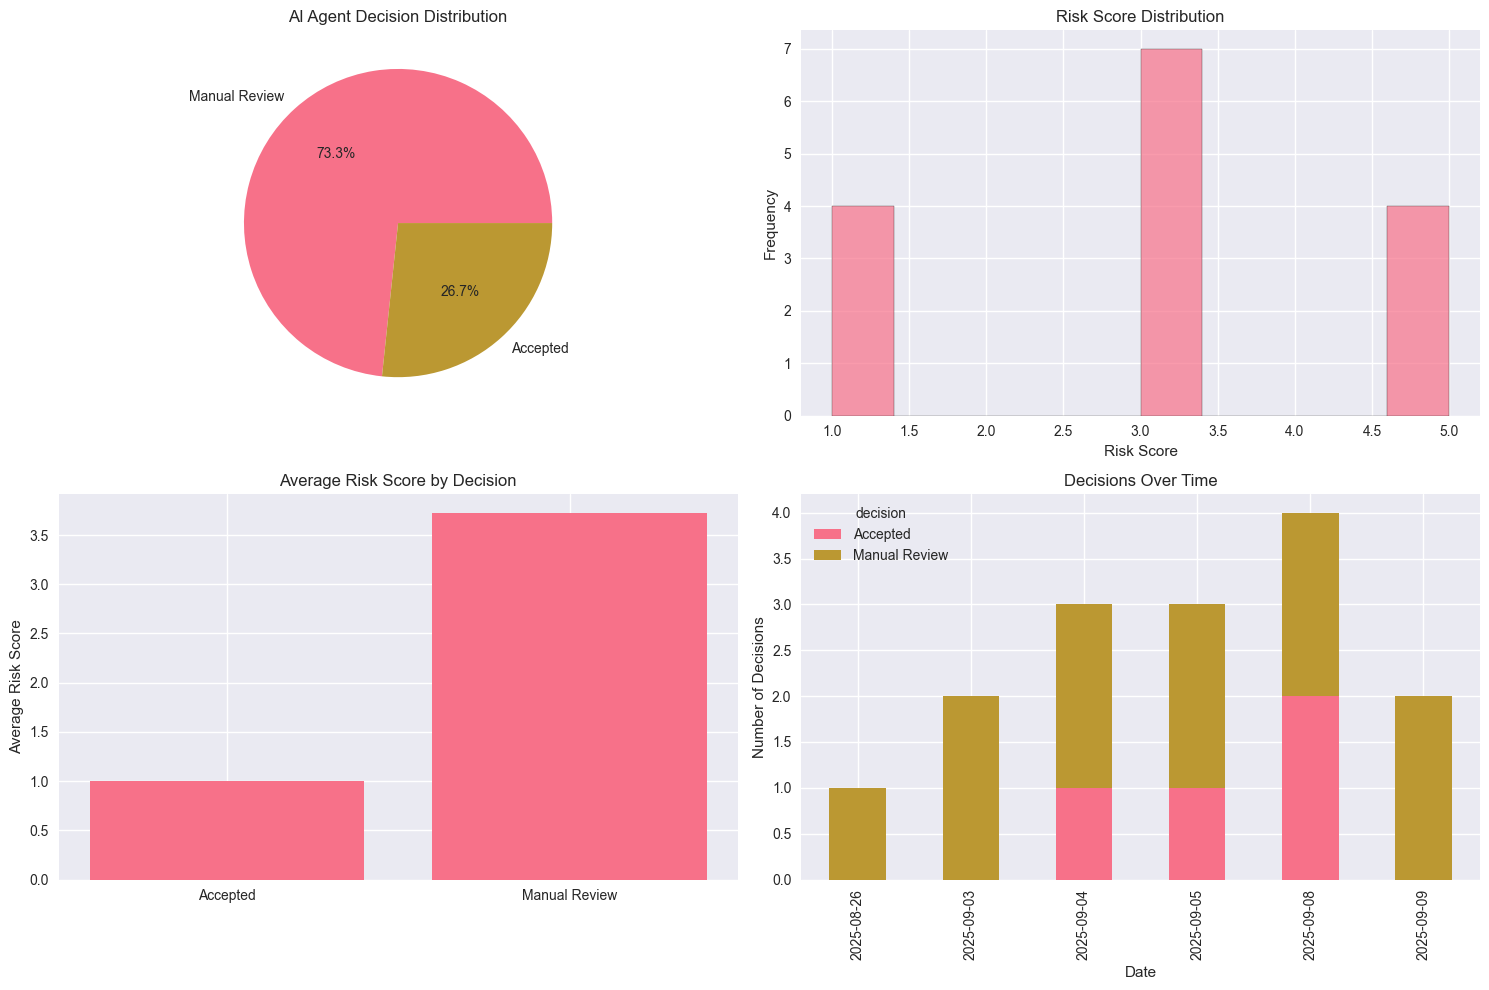

In [10]:
# 2. AI AGENT DECISION ANALYSIS
print("\n2. AI AGENT DECISION ANALYSIS")
print("-" * 40)

# Decision distribution
decision_counts = kyb_job_df['decision'].value_counts()
print("Decision Distribution:")
print(decision_counts)
print(f"Decision Rate: {decision_counts / len(kyb_job_df) * 100}")

# Risk score analysis
print(f"\nRisk Score Analysis:")
print(f"Mean Risk Score: {kyb_job_df['risk_score_numeric'].mean():.2f}")
print(f"Risk Score Range: {kyb_job_df['risk_score_numeric'].min()} - {kyb_job_df['risk_score_numeric'].max()}")
print(f"Risk Score Distribution:")
print(kyb_job_df['risk_score_numeric'].value_counts().sort_index())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Decision distribution
axes[0,0].pie(decision_counts.values, labels=decision_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('AI Agent Decision Distribution')

# Risk score distribution
axes[0,1].hist(kyb_job_df['risk_score_numeric'], bins=10, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Risk Score Distribution')
axes[0,1].set_xlabel('Risk Score')
axes[0,1].set_ylabel('Frequency')

# Decision vs Risk Score
decision_risk = kyb_job_df.groupby('decision')['risk_score_numeric'].mean()
axes[1,0].bar(decision_risk.index, decision_risk.values)
axes[1,0].set_title('Average Risk Score by Decision')
axes[1,0].set_ylabel('Average Risk Score')

# Timeline analysis
kyb_job_df['date'] = kyb_job_df['created_at'].dt.date
daily_decisions = kyb_job_df.groupby(['date', 'decision']).size().unstack(fill_value=0)
daily_decisions.plot(kind='bar', stacked=True, ax=axes[1,1])
axes[1,1].set_title('Decisions Over Time')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Number of Decisions')

plt.tight_layout()
plt.show()